# Smarticle Simulation Data Visualization and Processing

In [1]:
%load_ext autoreload
%autoreload 2

# Preliminaries

In [2]:
import time
import numpy as np
import smarticlesimulation as sim
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
# %matplotlib widget

###########
# Load data
# skip = 6
data_path = '../data/'
file = "combined_24inits_40Hz.csv"
data = np.genfromtxt(data_path+file, delimiter=",")
# file = "2020-10-13_sim_randinit_10_240Hz_file_2.csv"
# data2 = np.genfromtxt(data_path+file, delimiter=",")
# temp = np.vstack([data1,data2[::skip]])
# data = temp
# np.savetxt(data_path+"combined_24inits_40Hz.csv", data, delimiter=",")

# Preprocessing and Plotting

In [3]:
Ns = 3; fs = 40.
norm_len = 1./12. 
t_data = np.linspace(0,data.shape[0]/fs,data.shape[0])
x_unscaled = data[:,:3*Ns:3]
y_unscaled = data[:,1:3*Ns:3]
theta = data[:,2:3*Ns:3]
centroid = np.array([np.mean(x_unscaled,axis=1),np.mean(y_unscaled,axis=1)])
origin = np.array([np.mean(centroid[0]),np.mean(centroid[1])])

# Scaled data
x = (x_unscaled-origin[0])/norm_len
y = (y_unscaled-origin[1])/norm_len

# Preprocess into observables
prep_data = np.vstack([x.T[0],y.T[0],theta.T[0],x.T[1],y.T[1],theta.T[1],x.T[2],y.T[2],theta.T[2]]).T
%time observables = sim.preprocess(prep_data)

Wall time: 16.7 s


## Trajectory Plots

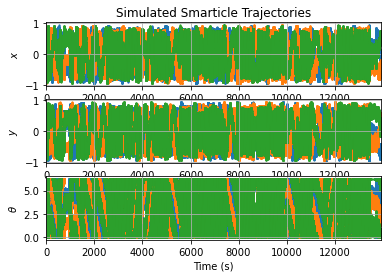

In [4]:
plt.figure()
plt.subplot(3,1,1)
plt.title('Simulated Smarticle Trajectories')
plt.scatter(t_data,x.T[0],s=1.5)
plt.scatter(t_data,x.T[1],s=1.5)
plt.scatter(t_data,x.T[2],s=1.5)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$x$')
plt.grid(True)

plt.subplot(3,1,2)
plt.scatter(t_data,y.T[0],s=1.5)
plt.scatter(t_data,y.T[1],s=1.5)
plt.scatter(t_data,y.T[2],s=1.5)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$y$')
plt.grid(True)

plt.subplot(3,1,3)
plt.scatter(t_data,theta.T[0],s=1.5)
plt.scatter(t_data,theta.T[1],s=1.5)
plt.scatter(t_data,theta.T[2],s=1.5)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$\theta$')
plt.xlabel('Time (s)')
plt.grid(True)
plt.show()

## Removing Random Shuffle Data


In [5]:
trial_inds = data[:,-1]
t_vec = t_data[np.where(trial_inds>0)]
x_vec = x[np.where(trial_inds>0)].T
y_vec = y[np.where(trial_inds>0)].T
theta_vec = theta[np.where(trial_inds>0)].T

## Plots Without Random Data

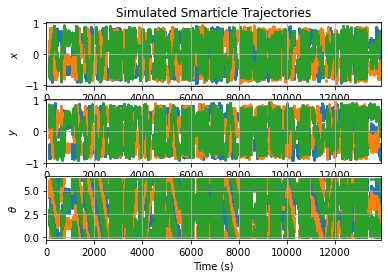

In [6]:
plt.figure()
plt.subplot(3,1,1)
plt.title('Simulated Smarticle Trajectories')
plt.scatter(t_vec,x_vec[0],s=1.5)
plt.scatter(t_vec,x_vec[1],s=1.5)
plt.scatter(t_vec,x_vec[2],s=1.5)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$x$')
plt.grid(True)

plt.subplot(3,1,2)
plt.scatter(t_vec,y_vec[0],s=1.5)
plt.scatter(t_vec,y_vec[1],s=1.5)
plt.scatter(t_vec,y_vec[2],s=1.5)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$y$')
plt.grid(True)

plt.subplot(3,1,3)
plt.scatter(t_vec,theta_vec[0],s=1.5)
plt.scatter(t_vec,theta_vec[1],s=1.5)
plt.scatter(t_vec,theta_vec[2],s=1.5)
plt.xlim([t_data[0], t_data[-1]])
plt.ylabel(r'$\theta$')
plt.xlabel('Time (s)')
plt.grid(True)
plt.show()

# Processing

## Calculating Rattling Over Trajectories

Wall time: 41.4 s


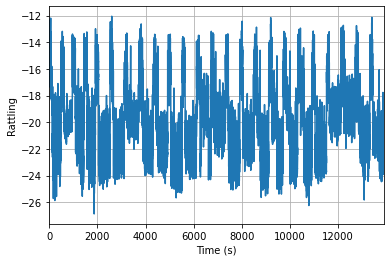

In [7]:
# Calculate rattling over windows of the time-series
dt = np.mean(np.diff(t_data))
T = 6; ov = 1; w_sz = int(T/dt); N = 25;
%time rats, covs, _ = sim.rattling_windows(observables,dt,w_sz,ov)

# Plotting
plt.figure()
plt.plot(t_data[:2-w_sz-N],sim.moving_average(rats,N))
plt.xlabel('Time (s)')
plt.ylabel('Rattling')
plt.xlim([t_data[0],t_data[2-w_sz-N]])
# plt.ylim([-40,-10])
plt.grid(True)
plt.show()

## Getting U-Shapes

In [8]:
gait_restart_ind = np.max(data[:,-2])-1
temp = np.where(np.diff(data[:,-2])<-gait_restart_ind)[0]
u_inds = temp[np.where(temp<len(rats))]
rat_vec = np.array(rats)[u_inds]

## Driven Steady-State Plot

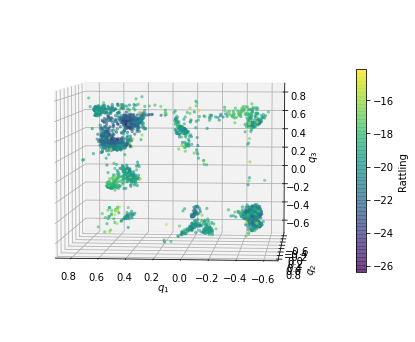

In [9]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
skip=2; col = rat_vec[::skip]
im = ax.scatter(observables[u_inds[::skip],1],observables[u_inds[::skip],0],observables[u_inds[::skip],2],c=col,s=5,alpha=0.5)
ax.view_init(elev=5, azim=95)
ax.set_xlabel(r'$q_1$')
ax.set_ylabel(r'$q_2$')
ax.set_zlabel(r'$q_3$')
cbar = fig.colorbar(im,shrink=0.6)
cbar.set_label('Rattling')
plt.tight_layout()
plt.show()

## Estimating Steady-State Probability Density

In [10]:
n_seed = 600; n_ss = 2000;
seed_inds = np.random.choice(list(range(len(rats))),n_seed)
ss_inds = np.random.choice(u_inds,n_ss)
rv_raw = np.array(rats)[seed_inds]
%time p_ss_raw = sim.estimate_pss(observables[seed_inds],observables[ss_inds],thresh=10) # input: seed points, p_ss points, inclusion threshold
p_ss = p_ss_raw[p_ss_raw>0]
rv = rv_raw[p_ss_raw>0]

Wall time: 50 s


## Estimating Correlation Slope

In [11]:
reg = LinearRegression().fit(rv.reshape(-1, 1), np.log(p_ss).reshape(-1, 1))
xv = np.linspace(-24,-14,100)
yv = reg.coef_*xv+reg.intercept_
r_squared = reg.score(rv.reshape(-1, 1), np.log(p_ss).reshape(-1, 1))

## Correlation Plot

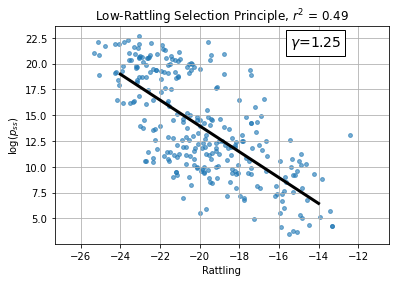

In [14]:
plt.figure()
plt.scatter(rv,np.log(p_ss),s=15,alpha=0.6)
plt.grid(True)
plt.plot(xv,yv[0],linewidth=3,c='k')
plt.text(np.max(rv)-3,np.max(np.log(p_ss))-1,r'$\gamma$='+str(np.round(np.abs(reg.coef_[0,0]),2)),fontsize=14,bbox=dict(facecolor='white', alpha=1))
plt.xlabel('Rattling')
plt.ylabel(r'log$(p_{ss})$')
plt.xlim([np.min(rv)-2,np.max(rv)+2])
plt.title(r'Low-Rattling Selection Principle, $r^2$ = '+str(np.round(r_squared,2)))
plt.show()

In [ ]:
plt.close('all')